# Pneumonia Detection Project
 
We have sone Image classification of X_ray images

Here two approaches are used one using CNN and VGG16.

VGG16 is existing model of convolution neural networks. 

We used it for transfer learning.

### Data Set used from kaggle 
-- https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/activity

## Mount the drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
#unzip
!unzip '/content/gdrive/MyDrive/PROJECTSS/Data Science Projects/Proj2-Pneumonia_detection/train_small.zip'

Archive:  /content/gdrive/MyDrive/PROJECTSS/Data Science Projects/Proj2-Pneumonia_detection/train_small.zip
   creating: train_small/
   creating: train_small/NORMAL/
  inflating: train_small/NORMAL/IM-0115-0001.jpeg  
  inflating: train_small/NORMAL/IM-0117-0001.jpeg  
  inflating: train_small/NORMAL/IM-0119-0001.jpeg  
  inflating: train_small/NORMAL/IM-0122-0001.jpeg  
  inflating: train_small/NORMAL/IM-0125-0001.jpeg  
  inflating: train_small/NORMAL/IM-0127-0001.jpeg  
  inflating: train_small/NORMAL/IM-0128-0001.jpeg  
  inflating: train_small/NORMAL/IM-0129-0001.jpeg  
  inflating: train_small/NORMAL/IM-0131-0001.jpeg  
  inflating: train_small/NORMAL/IM-0133-0001.jpeg  
  inflating: train_small/NORMAL/IM-0135-0001.jpeg  
  inflating: train_small/NORMAL/IM-0137-0001.jpeg  
  inflating: train_small/NORMAL/IM-0140-0001.jpeg  
  inflating: train_small/NORMAL/IM-0141-0001.jpeg  
  inflating: train_small/NORMAL/IM-0143-0001.jpeg  
  inflating: train_small/NORMAL/IM-0145-0001.jpeg  
 

In [ ]:
!unzip '/content/gdrive/MyDrive/PROJECTSS/Data Science Projects/Proj2-Pneumonia_detection/test_small.zip'

Archive:  /content/gdrive/MyDrive/PROJECTSS/Data Science Projects/Proj2-Pneumonia_detection/test_small.zip
   creating: test_small/
   creating: test_small/NORMAL/
  inflating: test_small/NORMAL/IM-0001-0001.jpeg  
  inflating: test_small/NORMAL/IM-0003-0001.jpeg  
  inflating: test_small/NORMAL/IM-0005-0001.jpeg  
  inflating: test_small/NORMAL/IM-0006-0001.jpeg  
  inflating: test_small/NORMAL/IM-0007-0001.jpeg  
  inflating: test_small/NORMAL/IM-0009-0001.jpeg  
  inflating: test_small/NORMAL/IM-0010-0001.jpeg  
  inflating: test_small/NORMAL/IM-0011-0001-0001.jpeg  
  inflating: test_small/NORMAL/IM-0011-0001-0002.jpeg  
  inflating: test_small/NORMAL/IM-0011-0001.jpeg  
  inflating: test_small/NORMAL/IM-0013-0001.jpeg  
  inflating: test_small/NORMAL/IM-0015-0001.jpeg  
  inflating: test_small/NORMAL/IM-0016-0001.jpeg  
  inflating: test_small/NORMAL/IM-0017-0001.jpeg  
  inflating: test_small/NORMAL/IM-0019-0001.jpeg  
  inflating: test_small/NORMAL/IM-0021-0001.jpeg  
  inflatin

In [ ]:
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Flatten #, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
# from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
# from keras.preprocessing.image import img_to_array,load_img
# from tensorflow.keras.utils import Sequence
import cv2
import numpy as np
# from glob import glob
# import matplotlib.pyplot as plt
# import seaborn as sns
import os
import pandas as pd
# sns.set_style("whitegrid")

In [ ]:
# VGG model requires 224*244 input so we are going to re-size all images
IMAGE_SIZE = [224, 224]

In [ ]:
train_path = 'train_small'
valid_path = 'test_small'

# LOad Data by Generator

Generator can create random variations in the given images for generalization of training

In [ ]:
# example of progressively loading images from file
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create generator 
datagen = ImageDataGenerator(rescale = 1./255,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                            horizontal_flip = True,
                             vertical_flip=True,
                             rotation_range=30)
# prepare an iterators for each dataset
train_it = datagen.flow_from_directory('./train_small/', 
                                       class_mode='categorical',
                                       target_size=(224, 224),
                                       batch_size=2,
                                       seed=7)
val_it = datagen.flow_from_directory('./test_small/', 
                                       class_mode='categorical',
                                       target_size=(224, 224),
                                       batch_size=2,
                                       seed=7)
test_it = datagen.flow_from_directory('./test_small/',  
                                       class_mode='categorical',
                                       target_size=(224, 224),
                                       batch_size=2,
                                       seed=7)
# confirm the iterator works
batchX, batchy = train_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Found 101 images belonging to 2 classes.
Found 46 images belonging to 2 classes.
Found 46 images belonging to 2 classes.
Batch shape=(2, 224, 224, 3), min=0.000, max=0.994


# VGG16 Model (Transfer Learning)

#### add preprocessing layer to the front of VGG 
#### [3] add 3 Channles ie RGB 
#### We are importing weights from imagenet use it as it is
#### include_top means we last layer in VGG16 Model we dont want this 
#### Because with help of VGG we are tyring to solve own problem

In [ ]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 0s 0us/step


## Don't train existing weights

In [ ]:
for layer in vgg.layers:
  layer.trainable = False

# Add Our Layers at End of VGG16

In [ ]:
output_classes = 2

In [ ]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
x = Dense(1000, activation='relu')(x)
# x = Dense(500, activation='relu')(x) 
prediction = Dense(output_classes, activation='softmax')(x)

In [ ]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
history_vgg= model.fit(
  train_it,
  validation_data=val_it,
  epochs=5
  # steps_per_epoch=train_size,
  # validation_steps=validation_size
)

Epoch 1/5
51/51 [==============================] - 86s 2s/step - loss: 1.1498 - accuracy: 0.7921 - val_loss: 1.6274 - val_accuracy: 0.6304
Epoch 2/5
51/51 [==============================] - 85s 2s/step - loss: 0.2308 - accuracy: 0.9406 - val_loss: 0.6148 - val_accuracy: 0.8043
Epoch 3/5
51/51 [==============================] - 85s 2s/step - loss: 0.2257 - accuracy: 0.9307 - val_loss: 0.5968 - val_accuracy: 0.8261
Epoch 4/5
51/51 [==============================] - 85s 2s/step - loss: 0.2266 - accuracy: 0.9604 - val_loss: 0.7107 - val_accuracy: 0.7609
Epoch 5/5
51/51 [==============================] - 85s 2s/step - loss: 0.1741 - accuracy: 0.9604 - val_loss: 1.2034 - val_accuracy: 0.6957


In [ ]:
history_vgg.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

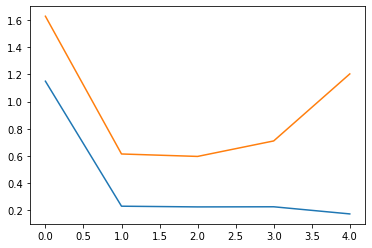

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])

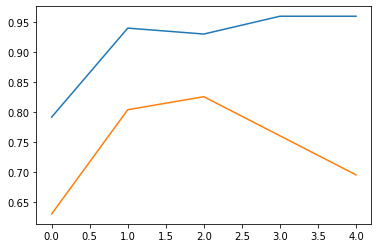

In [ ]:
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])

# Resnet50 Model

In [ ]:
from tensorflow.keras.applications import ResNet50

In [ ]:
resnet = ResNet50(include_top=True,weights="imagenet",input_shape=(224,224,3),classes=1000)

102973440/102967424 [==============================] - 1s 0us/step


In [ ]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
for layer in resnet.layers[:-2]:
  layer.trainable = False

# Add Our Layers at End of Resnet50

In [ ]:
output_classes = 2

In [ ]:
# our layers - you can add more if you want
x = Flatten()(resnet.layers[-2].output)
x = Dense(1000, activation='relu')(x)
# x = Dense(500, activation='relu')(x) 
prediction = Dense(output_classes, activation='softmax')(x)

In [ ]:
# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
history_resnet= model.fit(
  train_it,
  validation_data=val_it,
  epochs=5
  )

Epoch 1/5
51/51 [==============================] - 34s 607ms/step - loss: 0.7912 - accuracy: 0.7030 - val_loss: 1.1463 - val_accuracy: 0.5000
Epoch 2/5
51/51 [==============================] - 30s 585ms/step - loss: 0.5989 - accuracy: 0.7723 - val_loss: 1.3021 - val_accuracy: 0.5000
Epoch 3/5
51/51 [==============================] - 30s 590ms/step - loss: 0.5594 - accuracy: 0.7624 - val_loss: 1.1121 - val_accuracy: 0.5000
Epoch 4/5
51/51 [==============================] - 30s 583ms/step - loss: 0.6008 - accuracy: 0.7228 - val_loss: 1.4165 - val_accuracy: 0.5000
Epoch 5/5
51/51 [==============================] - 30s 585ms/step - loss: 0.5193 - accuracy: 0.7822 - val_loss: 0.9182 - val_accuracy: 0.5000


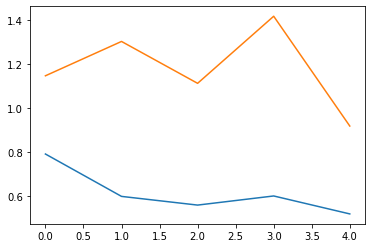

In [ ]:
plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])

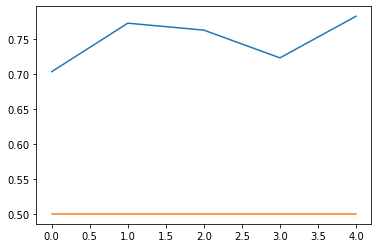

In [ ]:
plt.plot(history_resnet.history['accuracy'])
plt.plot(history_resnet.history['val_accuracy'])